# Laboratorio 5
## Código de entrenmiento del modelo
### Luis Brenes Campos - C21324
### Elizabeth Matamoros - C04652

# I SEMESTRE 2025

## Setear el ambiente necesario para el modelo

The next cell sets up the dependencies in required for the notebook, run it.

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.12.0

# Subir archivos

1. Al lado izquirdo dar click en el símbolo de carpeta y seguidamente en cargar archivos.
2. Seleccione los .csv correspondientes a los 3 movimientos

# Gráfica de los datos

/tmp/ipython-input-2-42160311.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
/tmp/ipython-input-2-42160311.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
/tmp/ipython-input-2-42160311.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


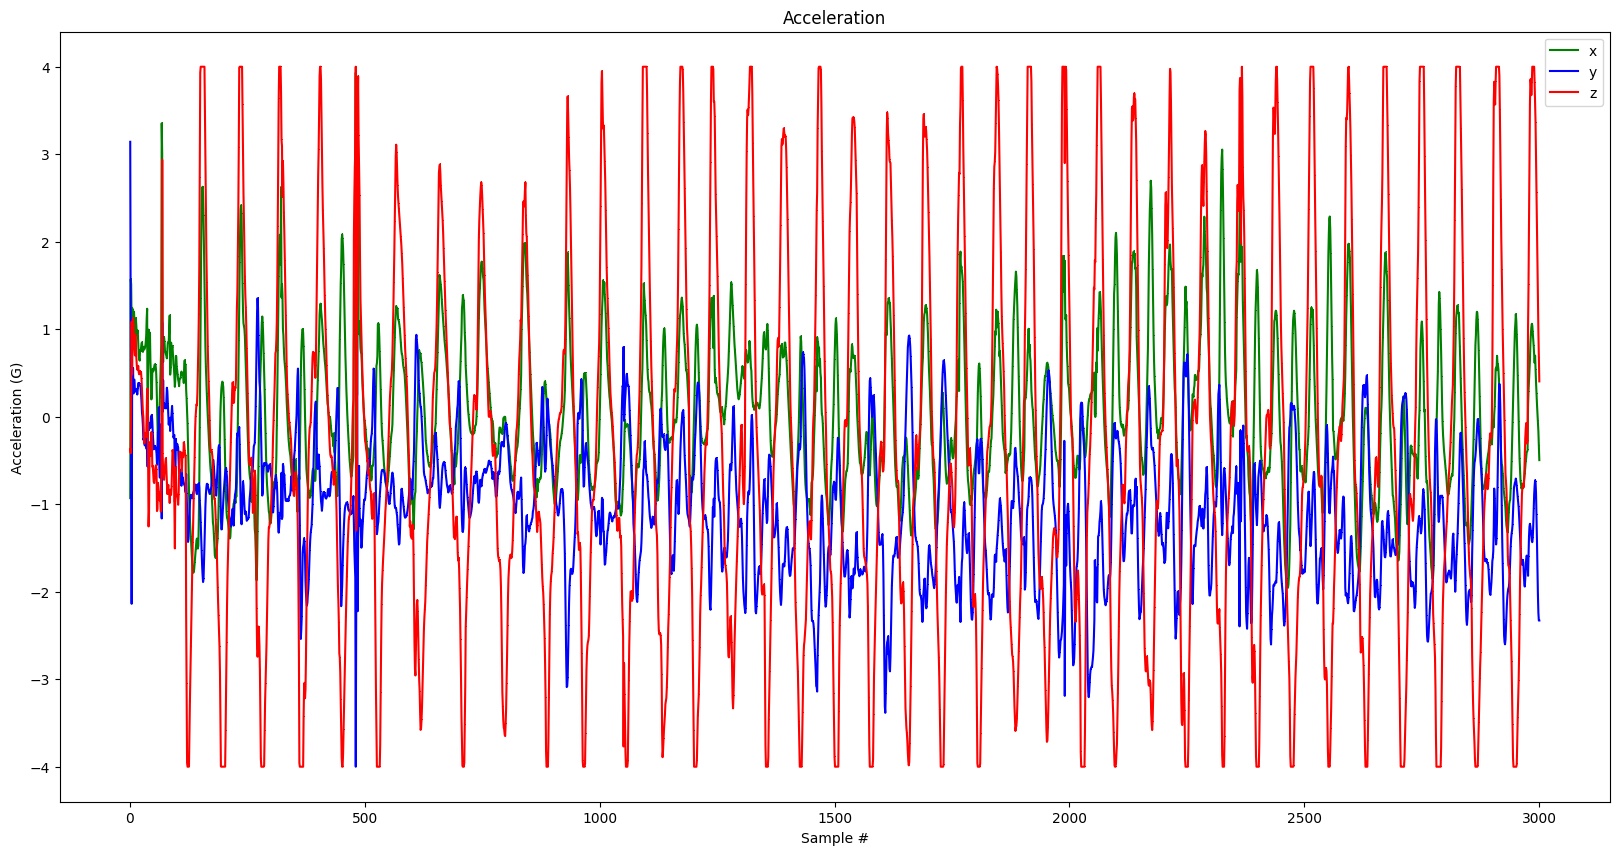

/tmp/ipython-input-2-42160311.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
/tmp/ipython-input-2-42160311.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
/tmp/ipython-input-2-42160311.py:28: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


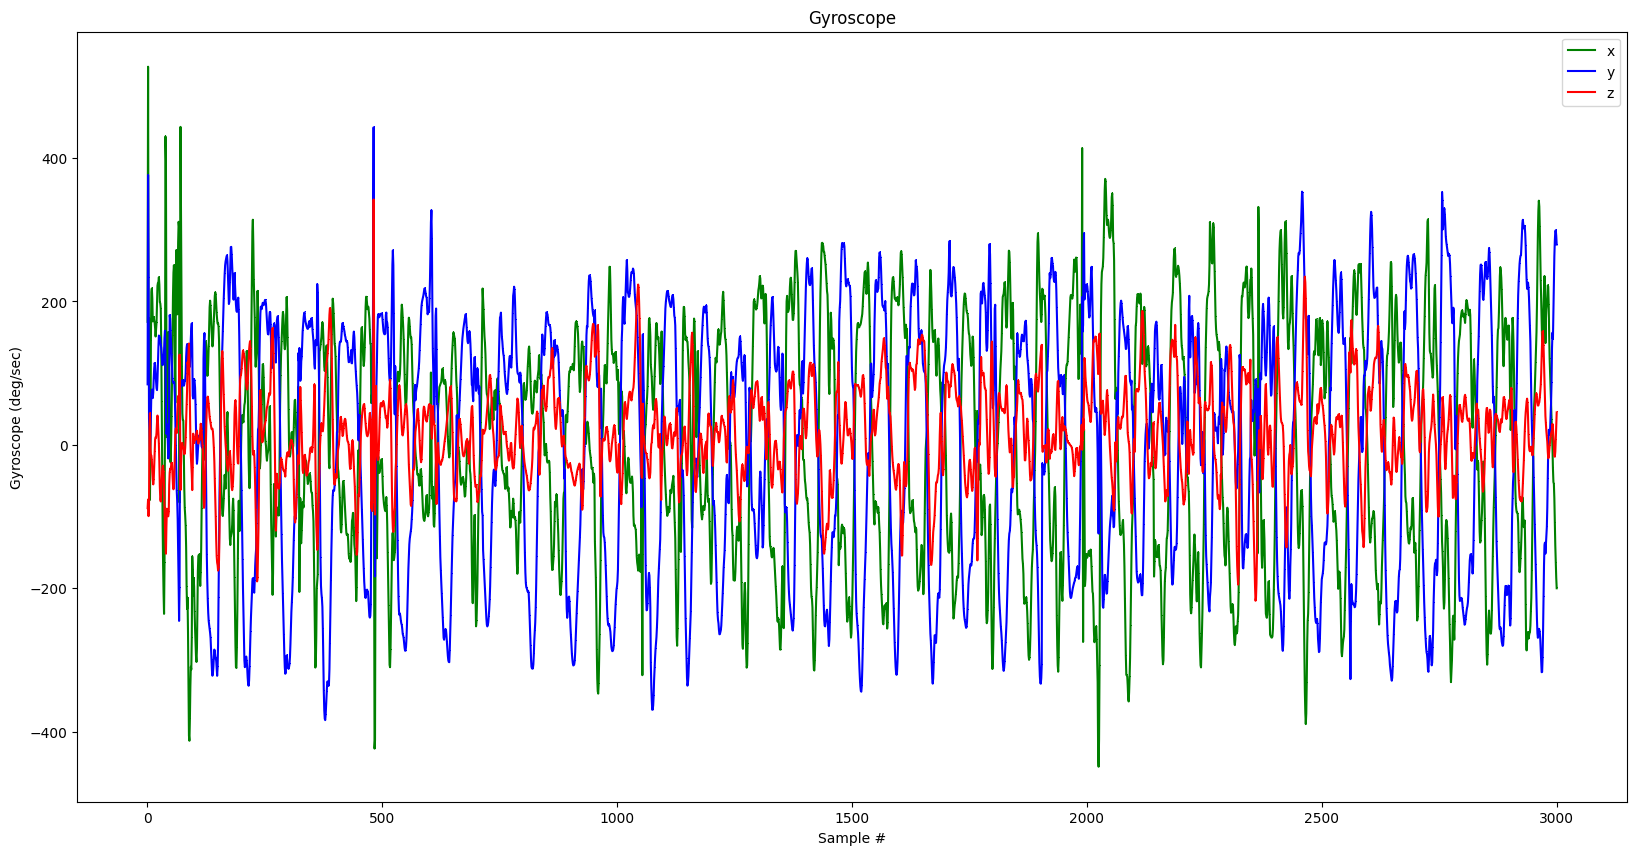

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "clap.csv"

df = pd.read_csv("/content/" + filename, sep=';')

# Assuming the columns are named 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ' after fixing separator
df.columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']


index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

# Entrenamiento





## Administración de datos


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "circles",
    "clap",
    "updown",
]

SAMPLES_PER_GESTURE = 150

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv", sep=';')

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.12.0

Processing index 0 for gesture 'circles'.
	There are 20 recordings of the circles gesture.
Processing index 1 for gesture 'clap'.
	There are 20 recordings of the clap gesture.
Processing index 2 for gesture 'updown'.
	There are 20 recordings of the updown gesture.
Data set parsing and preparation complete.


## Randomizado y separación de datos

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Configuración del modelo
Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
36/36 [==============================] - 1s 6ms/step - loss: 0.2523 - mae: 0.4499 - val_loss: 0.2243 - val_mae: 0.4453
Epoch 2/600
36/36 [==============================] - 0s 2ms/step - loss: 0.2135 - mae: 0.4197 - val_loss: 0.3226 - val_mae: 0.4630
Epoch 3/600
36/36 [==============================] - 0s 2ms/step - loss: 0.2219 - mae: 0.4095 - val_loss: 0.2295 - val_mae: 0.4484
Epoch 4/600
36/36 [==============================] - 0s 2ms/step - loss: 0.2217 - mae: 0.4369 - val_loss: 0.2283 - val_mae: 0.4446
Epoch 5/600
36/36 [==============================] - 0s 2ms/step - loss: 0.2095 - mae: 0.4212 - val_loss: 0.2258 - val_mae: 0.4410
Epoch 6/600
36/36 [==============================] - 0s 2ms/step - loss: 0.1993 - mae: 0.4081 - val_loss: 0.2165 - val_mae: 0.4346
Epoch 7/600
36/36 [==============================] - 0s 2ms/step - loss: 0.1783 - mae: 0.3763 - val_loss: 0.2191 - val_mae: 0.4273
Epoch 8/600
36/36 [==============================] - 0s 2ms/step - loss: 0.1898 - m

## Verifación y validación del modelo


### Gráfica de pérdidas

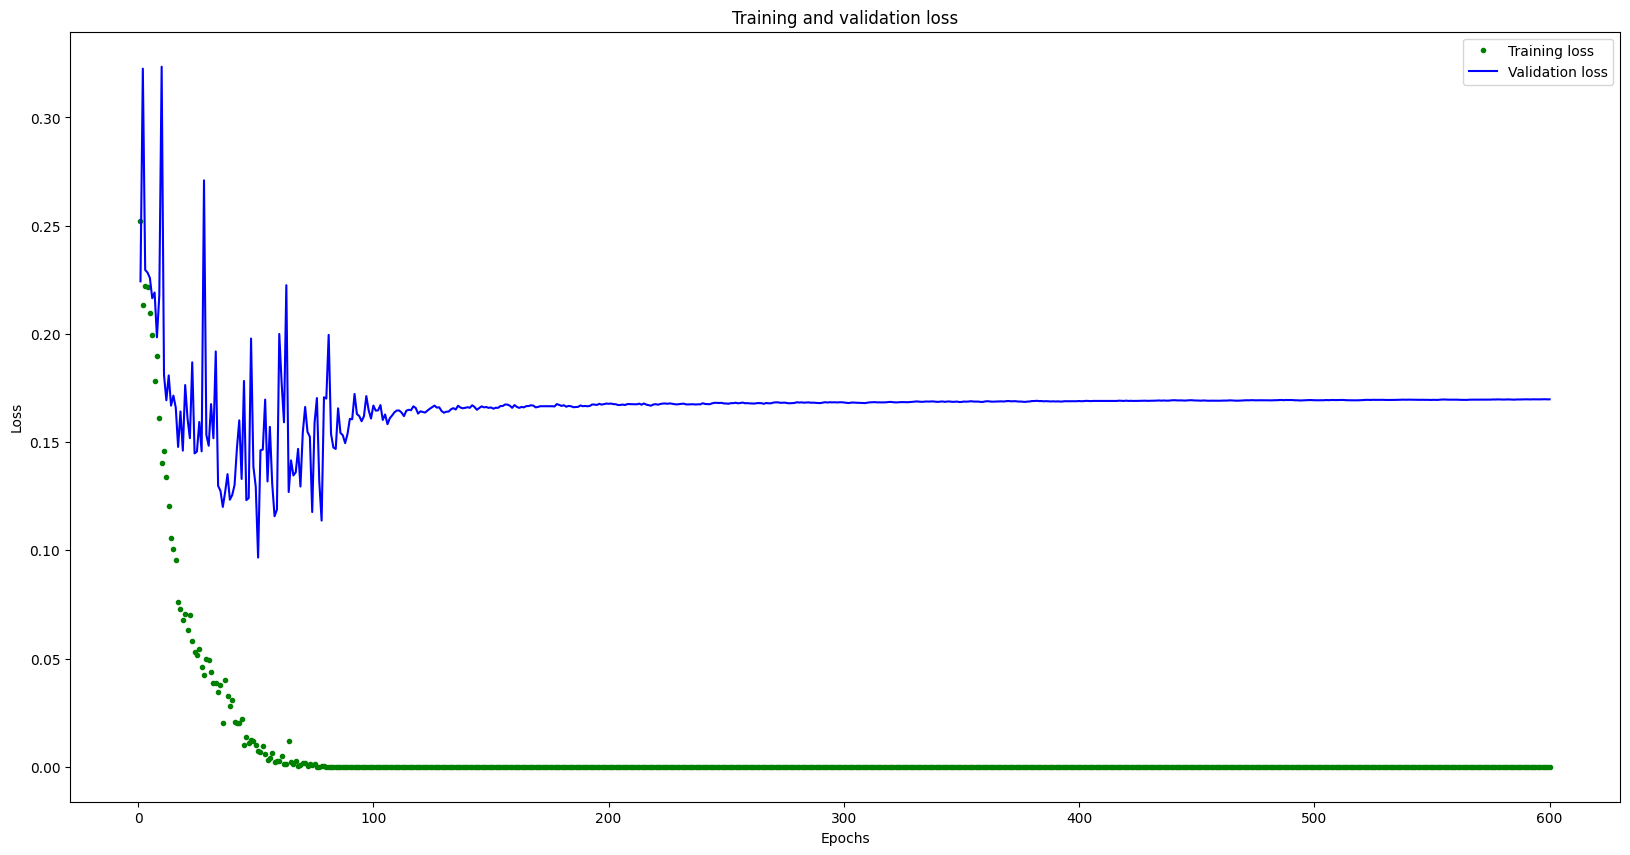

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

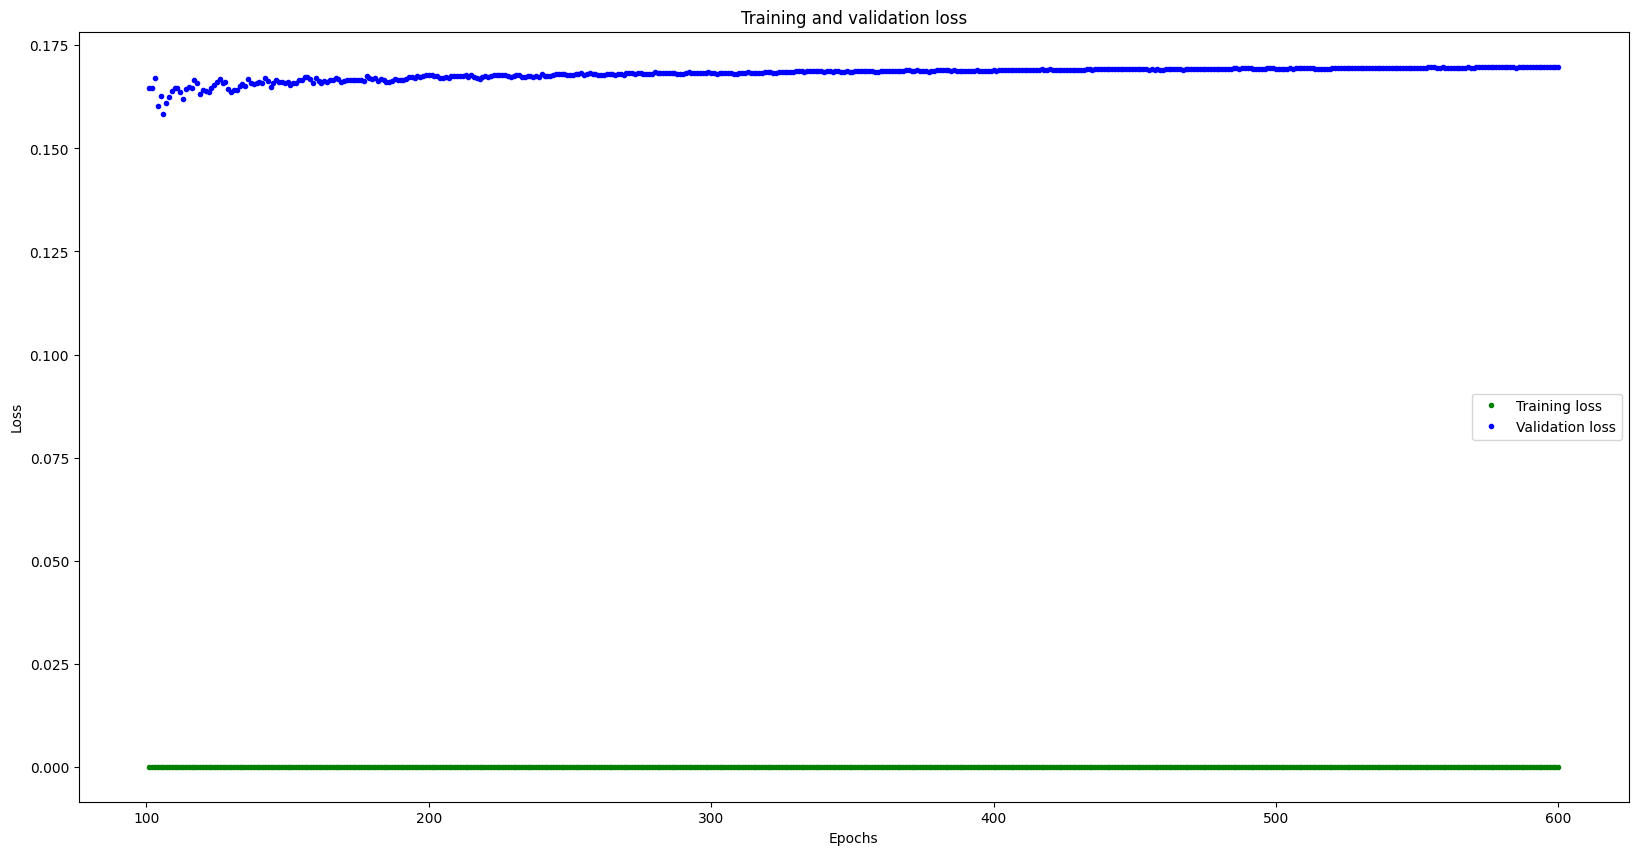

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Gráfica del MAE



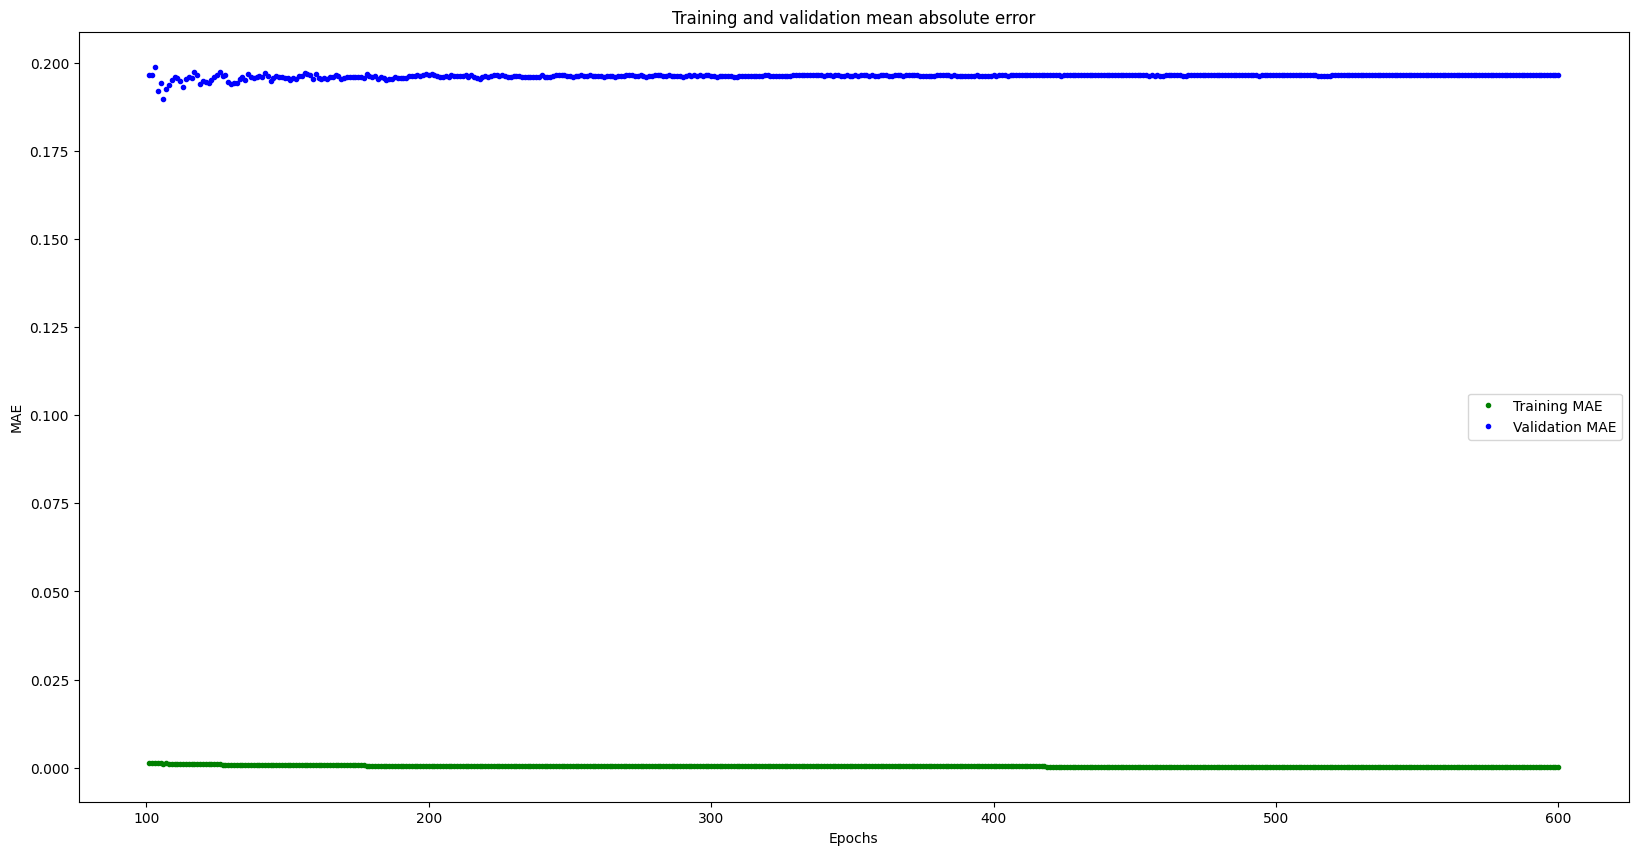

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


  ### Testeo con otros datos


In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# # Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
# plt.plot(inputs_test, predictions, 'r.', label='Predicted')
# plt.show()

1/1 [==============================] - 0s 22ms/step
predictions =
 [[0.008 0.002 0.99 ]
 [0.997 0.    0.003]
 [0.494 0.    0.506]
 [0.004 0.698 0.298]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [0.934 0.001 0.065]
 [0.002 0.834 0.164]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.939 0.    0.061]]
actual =
 [[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


# Conversión del modelo a .tflite

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)



Model is 185544 bytes


## Conversión del modelo .tflite al .h

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,144,222 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
